# DEAM Dataset - Feed Forward Neural Network
## Essentia Best Overall & openSMILE ComParE2016 Featureset

## Import relevant libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics import R2Score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import math

import sys
sys.path.insert(1, '../../utils')
from paths import *

## Neural Network Training

### Import annotations dataset

In [2]:
df_annotations = pd.read_csv(get_deam_path('processed/annotations/deam_static_annotations.csv'))
df_annotations

,song_id,valence_mean_mapped,arousal_mean_mapped
0,2,-0.475,-0.500
1,3,-0.375,-0.425
2,4,0.175,0.125
3,5,-0.150,0.075
4,7,0.200,0.350
...,...,...,...
1739,1996,-0.275,0.225
1740,1997,0.075,-0.275
1741,1998,0.350,0.300
1742,1999,-0.100,0.100


### Import the featureset

This is where you should change between normalised and standardised, and untouched featuresets!

In [3]:
df_essentia_best_overall_opensmile_compare2016_features = pd.read_csv(get_deam_path('processed/features/integrated/standardised_essentia_best_overall_opensmile_compare2016_features.csv'))

# drop Unnamed:0 column
df_essentia_best_overall_opensmile_compare2016_features = df_essentia_best_overall_opensmile_compare2016_features[df_essentia_best_overall_opensmile_compare2016_features.columns[1:]]

df_essentia_best_overall_opensmile_compare2016_features

,song_id,lowlevel.melbands_kurtosis.dmean,lowlevel.melbands_kurtosis.dmean2,lowlevel.melbands_kurtosis.dvar,lowlevel.melbands_kurtosis.dvar2,lowlevel.melbands_kurtosis.max,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_kurtosis.median,lowlevel.melbands_kurtosis.min,lowlevel.melbands_kurtosis.stdev,...,mfcc_sma_de[14]_peakRangeAbs,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope
0,2,-0.092381,-0.078572,-0.025137,-0.024931,-0.051278,-0.058571,-0.055109,0.361562,-0.018698,...,-0.631867,-0.365685,-0.279802,-0.282638,1.033912,1.253936,0.258343,-0.101681,0.267050,-0.103648
1,3,0.073364,0.050761,-0.025077,-0.024890,-0.020349,1.479718,3.014248,0.583826,0.056605,...,-0.952109,-1.043699,-0.949817,-0.947268,-0.967357,0.042120,-1.127785,-0.883942,-1.084239,-0.561874
2,4,-0.119333,-0.107505,-0.025174,-0.024965,-0.083147,-0.208423,-0.075820,0.053745,-0.094185,...,-0.252214,-0.788912,-0.139047,-0.140901,1.033912,0.889151,-0.026883,0.089203,-0.241184,-0.576476
3,5,-0.163481,-0.139436,-0.025195,-0.024978,-0.094325,-0.262338,-0.148097,-0.493194,-0.110313,...,-0.484816,-1.100697,-0.386997,-0.392154,1.033909,0.387215,-0.513832,-0.330955,-0.729651,-0.400833
4,7,0.721637,0.521923,-0.024526,-0.024479,0.015265,2.154544,4.094221,0.492728,0.184390,...,-0.679149,0.063000,-1.232202,-1.229221,-0.967357,0.368769,-1.143719,-1.322279,-1.174207,-1.294879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,1996,-0.154993,-0.129360,-0.025193,-0.024975,-0.100449,-0.321333,-0.138527,0.145668,-0.130138,...,-0.774443,0.503124,-0.529866,-0.535381,1.033905,-0.030763,-0.263638,-0.737909,0.002047,-0.727175
1740,1997,-0.169892,-0.137550,-0.025197,-0.024978,-0.102115,-0.346532,-0.290196,-0.205395,-0.126981,...,-0.029122,-0.435924,-0.013004,-0.020709,1.033884,-0.033798,0.353010,0.525906,0.453648,0.424850
1741,1998,-0.106021,-0.088136,-0.025128,-0.024919,-0.035307,-0.242062,-0.115127,-0.427167,-0.093478,...,-0.697061,1.159923,-0.806402,-0.809586,1.033912,-0.252968,-0.728777,-1.008194,-0.453289,-0.757926
1742,1999,-0.124002,-0.105158,-0.025185,-0.024971,-0.068508,-0.098127,0.316466,1.586562,-0.104839,...,-0.391407,1.480851,-0.725574,-0.727505,1.033912,-0.852857,-0.127534,-0.522571,-0.095621,-0.490813


In [4]:
df_essentia_best_overall_opensmile_compare2016_features.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 6510 columns):
 #     Column                                                    Dtype  
---    ------                                                    -----  
 0     song_id                                                   int64  
 1     lowlevel.melbands_kurtosis.dmean                          float64
 2     lowlevel.melbands_kurtosis.dmean2                         float64
 3     lowlevel.melbands_kurtosis.dvar                           float64
 4     lowlevel.melbands_kurtosis.dvar2                          float64
 5     lowlevel.melbands_kurtosis.max                            float64
 6     lowlevel.melbands_kurtosis.mean                           float64
 7     lowlevel.melbands_kurtosis.median                         float64
 8     lowlevel.melbands_kurtosis.min                            float64
 9     lowlevel.melbands_kurtosis.stdev                          float64
 10    lowlevel

Join both the featureset and annotation set together

In [5]:
df_essentia_best_overall_opensmile_compare2016_whole = pd.merge(df_essentia_best_overall_opensmile_compare2016_features, df_annotations, how='inner', on='song_id')
df_essentia_best_overall_opensmile_compare2016_whole = df_essentia_best_overall_opensmile_compare2016_whole.drop('song_id', axis=1)
df_essentia_best_overall_opensmile_compare2016_whole

,lowlevel.melbands_kurtosis.dmean,lowlevel.melbands_kurtosis.dmean2,lowlevel.melbands_kurtosis.dvar,lowlevel.melbands_kurtosis.dvar2,lowlevel.melbands_kurtosis.max,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_kurtosis.median,lowlevel.melbands_kurtosis.min,lowlevel.melbands_kurtosis.stdev,lowlevel.melbands_kurtosis.var,...,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope,valence_mean_mapped,arousal_mean_mapped
0,-0.092381,-0.078572,-0.025137,-0.024931,-0.051278,-0.058571,-0.055109,0.361562,-0.018698,-0.026304,...,-0.279802,-0.282638,1.033912,1.253936,0.258343,-0.101681,0.267050,-0.103648,-0.475,-0.500
1,0.073364,0.050761,-0.025077,-0.024890,-0.020349,1.479718,3.014248,0.583826,0.056605,-0.025526,...,-0.949817,-0.947268,-0.967357,0.042120,-1.127785,-0.883942,-1.084239,-0.561874,-0.375,-0.425
2,-0.119333,-0.107505,-0.025174,-0.024965,-0.083147,-0.208423,-0.075820,0.053745,-0.094185,-0.026786,...,-0.139047,-0.140901,1.033912,0.889151,-0.026883,0.089203,-0.241184,-0.576476,0.175,0.125
3,-0.163481,-0.139436,-0.025195,-0.024978,-0.094325,-0.262338,-0.148097,-0.493194,-0.110313,-0.026850,...,-0.386997,-0.392154,1.033909,0.387215,-0.513832,-0.330955,-0.729651,-0.400833,-0.150,0.075
4,0.721637,0.521923,-0.024526,-0.024479,0.015265,2.154544,4.094221,0.492728,0.184390,-0.023528,...,-1.232202,-1.229221,-0.967357,0.368769,-1.143719,-1.322279,-1.174207,-1.294879,0.200,0.350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,-0.154993,-0.129360,-0.025193,-0.024975,-0.100449,-0.321333,-0.138527,0.145668,-0.130138,-0.026911,...,-0.529866,-0.535381,1.033905,-0.030763,-0.263638,-0.737909,0.002047,-0.727175,-0.275,0.225
1740,-0.169892,-0.137550,-0.025197,-0.024978,-0.102115,-0.346532,-0.290196,-0.205395,-0.126981,-0.026903,...,-0.013004,-0.020709,1.033884,-0.033798,0.353010,0.525906,0.453648,0.424850,0.075,-0.275
1741,-0.106021,-0.088136,-0.025128,-0.024919,-0.035307,-0.242062,-0.115127,-0.427167,-0.093478,-0.026783,...,-0.806402,-0.809586,1.033912,-0.252968,-0.728777,-1.008194,-0.453289,-0.757926,0.350,0.300
1742,-0.124002,-0.105158,-0.025185,-0.024971,-0.068508,-0.098127,0.316466,1.586562,-0.104839,-0.026830,...,-0.725574,-0.727505,1.033912,-0.852857,-0.127534,-0.522571,-0.095621,-0.490813,-0.100,0.100


#### Prepare dataframes for the neural network

Perform splitting of the dataframe into training and testing sets

In [6]:
features = df_essentia_best_overall_opensmile_compare2016_features.drop('song_id', axis=1)
features

,lowlevel.melbands_kurtosis.dmean,lowlevel.melbands_kurtosis.dmean2,lowlevel.melbands_kurtosis.dvar,lowlevel.melbands_kurtosis.dvar2,lowlevel.melbands_kurtosis.max,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_kurtosis.median,lowlevel.melbands_kurtosis.min,lowlevel.melbands_kurtosis.stdev,lowlevel.melbands_kurtosis.var,...,mfcc_sma_de[14]_peakRangeAbs,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope
0,-0.092381,-0.078572,-0.025137,-0.024931,-0.051278,-0.058571,-0.055109,0.361562,-0.018698,-0.026304,...,-0.631867,-0.365685,-0.279802,-0.282638,1.033912,1.253936,0.258343,-0.101681,0.267050,-0.103648
1,0.073364,0.050761,-0.025077,-0.024890,-0.020349,1.479718,3.014248,0.583826,0.056605,-0.025526,...,-0.952109,-1.043699,-0.949817,-0.947268,-0.967357,0.042120,-1.127785,-0.883942,-1.084239,-0.561874
2,-0.119333,-0.107505,-0.025174,-0.024965,-0.083147,-0.208423,-0.075820,0.053745,-0.094185,-0.026786,...,-0.252214,-0.788912,-0.139047,-0.140901,1.033912,0.889151,-0.026883,0.089203,-0.241184,-0.576476
3,-0.163481,-0.139436,-0.025195,-0.024978,-0.094325,-0.262338,-0.148097,-0.493194,-0.110313,-0.026850,...,-0.484816,-1.100697,-0.386997,-0.392154,1.033909,0.387215,-0.513832,-0.330955,-0.729651,-0.400833
4,0.721637,0.521923,-0.024526,-0.024479,0.015265,2.154544,4.094221,0.492728,0.184390,-0.023528,...,-0.679149,0.063000,-1.232202,-1.229221,-0.967357,0.368769,-1.143719,-1.322279,-1.174207,-1.294879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,-0.154993,-0.129360,-0.025193,-0.024975,-0.100449,-0.321333,-0.138527,0.145668,-0.130138,-0.026911,...,-0.774443,0.503124,-0.529866,-0.535381,1.033905,-0.030763,-0.263638,-0.737909,0.002047,-0.727175
1740,-0.169892,-0.137550,-0.025197,-0.024978,-0.102115,-0.346532,-0.290196,-0.205395,-0.126981,-0.026903,...,-0.029122,-0.435924,-0.013004,-0.020709,1.033884,-0.033798,0.353010,0.525906,0.453648,0.424850
1741,-0.106021,-0.088136,-0.025128,-0.024919,-0.035307,-0.242062,-0.115127,-0.427167,-0.093478,-0.026783,...,-0.697061,1.159923,-0.806402,-0.809586,1.033912,-0.252968,-0.728777,-1.008194,-0.453289,-0.757926
1742,-0.124002,-0.105158,-0.025185,-0.024971,-0.068508,-0.098127,0.316466,1.586562,-0.104839,-0.026830,...,-0.391407,1.480851,-0.725574,-0.727505,1.033912,-0.852857,-0.127534,-0.522571,-0.095621,-0.490813


In [7]:
targets = df_annotations.drop('song_id', axis=1)
targets

,valence_mean_mapped,arousal_mean_mapped
0,-0.475,-0.500
1,-0.375,-0.425
2,0.175,0.125
3,-0.150,0.075
4,0.200,0.350
...,...,...
1739,-0.275,0.225
1740,0.075,-0.275
1741,0.350,0.300
1742,-0.100,0.100


Perform 80-20 train-test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

Create tensors for X_train and X_test

In [9]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float64)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float64)

Create tensors for Y_train and Y_test

In [10]:
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float64)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float64)

Define neural network parameters and instantitate neural network

In [11]:
input_size = 1
hidden_size = 20 
output_size = 2  # Output size for valence and arousal
learning_rate = 0.001
criterion = nn.MSELoss()

In [29]:
num_epochs = 192

Set a random seed to ensure consistent initial weights of the neural network

In [30]:
# Set the seed
seed = 42
torch.manual_seed(seed)

Define the neural network

In [31]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), 2)
        )

    def forward(self, x):
        return self.layers(x)

#### Training

Prepare input_train_data and target_train_labels

In [32]:
input_train_data = X_train_tensor.float()

# input_train_data = input_train_data.view(input_train_data.shape[1], -1)
print(input_train_data.shape)

target_train_labels = y_train_tensor

torch.Size([1395, 6509])


Training loop

In [33]:
def train_model(num_epochs):
  model = NeuralNetwork(input_size=input_train_data.shape[1])
  optimiser = optim.Adam(model.parameters(), lr=learning_rate)
  
  for epoch in range(num_epochs):
    optimiser.zero_grad()
    
    # forward pass
    output = model(input_train_data)

    # calculate loss
    loss = torch.sqrt(criterion(output.float(), target_train_labels.float()))

    # backward pass
    loss.backward()
    # update weights
    optimiser.step()

    print(f'Epoch {epoch + 1}, Loss: {math.sqrt(loss.item())}')

  print("Training completed.")
  return model

In [34]:
model = train_model(num_epochs)

Epoch 1, Loss: 0.5580484356111368
Epoch 2, Loss: 0.5563656579550821
Epoch 3, Loss: 0.5560089810730074
Epoch 4, Loss: 0.5557781833052516
Epoch 5, Loss: 0.5540087670930495
Epoch 6, Loss: 0.5495618483783455
Epoch 7, Loss: 0.5406569245454785
Epoch 8, Loss: 0.5248996752294087
Epoch 9, Loss: 0.5099545417422564
Epoch 10, Loss: 0.5107485477204665
Epoch 11, Loss: 0.4929746358432428
Epoch 12, Loss: 0.4869840251115866
Epoch 13, Loss: 0.47516505360248695
Epoch 14, Loss: 0.4640092652224114
Epoch 15, Loss: 0.46104457387454334
Epoch 16, Loss: 0.4604694770571661
Epoch 17, Loss: 0.4556534531687156
Epoch 18, Loss: 0.4512580359950669
Epoch 19, Loss: 0.44686125087260936
Epoch 20, Loss: 0.4428475572415536
Epoch 21, Loss: 0.4403857359344942
Epoch 22, Loss: 0.4381992338146857
Epoch 23, Loss: 0.43220396952441253
Epoch 24, Loss: 0.4317314259576565
Epoch 25, Loss: 0.4280124787924618
Epoch 26, Loss: 0.4239213550884029
Epoch 27, Loss: 0.4216583720089995
Epoch 28, Loss: 0.4188293794578661
Epoch 29, Loss: 0.4158221

## Neural Network Testing

Prepare input_test_data and target_test_labels

In [35]:
input_test_data = X_test_tensor.float()

# input_test_data = input_test_data.view(input_test_data.shape[1], -1)
print(input_test_data.shape)

target_test_labels = y_test_tensor

torch.Size([349, 6509])


Generating scores

In [36]:
def test_model(trained_model):
  with torch.no_grad():
    test_pred = trained_model(input_test_data)
    test_loss = criterion(test_pred.float(), target_test_labels)

  rmse = math.sqrt(test_loss.item())
  print(f'Test RMSE: {rmse}')

  metric = R2Score()
  metric.update(test_pred, target_test_labels)
  r2_score = metric.compute().item()
  print(f'Test R^2 score: {r2_score}')
  return test_pred, rmse, r2_score

In [37]:
test_pred, rmse, r2_score = test_model(model)

Test RMSE: 0.18839561922481116
Test R^2 score: 0.6125282892988142


True values (test set)

In [21]:
target_test_labels

tensor([[-0.1500, -0.1500],
        [-0.3000, -0.1000],
        [ 0.2000,  0.3500],
        [ 0.2250,  0.4500],
        [-0.1750, -0.2000],
        [-0.5250, -0.3000],
        [-0.2500, -0.7750],
        [ 0.3000,  0.3000],
        [-0.1750, -0.4000],
        [ 0.4500,  0.1500],
        [ 0.1750,  0.0250],
        [-0.1750, -0.0250],
        [-0.0500, -0.3000],
        [ 0.1250,  0.3000],
        [-0.0750, -0.1500],
        [-0.2000, -0.2750],
        [-0.6000, -0.2250],
        [ 0.1500, -0.2000],
        [ 0.2750,  0.6000],
        [-0.1500, -0.4500],
        [-0.2250, -0.6250],
        [-0.0250, -0.4500],
        [-0.5250, -0.1250],
        [ 0.0000,  0.3250],
        [ 0.1250,  0.3750],
        [ 0.1500, -0.2500],
        [ 0.4500,  0.3250],
        [ 0.2500,  0.2250],
        [-0.1000,  0.0750],
        [ 0.4250,  0.1250],
        [-0.4500, -0.3500],
        [-0.0500,  0.3750],
        [-0.4750, -0.2000],
        [-0.2750, -0.4000],
        [-0.4000, -0.2250],
        [ 0.1000, -0

Predicted values

In [22]:
test_pred

tensor([[ 1.4352e-01,  8.1411e-02],
        [-2.5840e-01, -2.2065e-01],
        [ 4.7599e-01,  3.8684e-01],
        [ 1.5959e-01,  3.9314e-01],
        [-1.3262e-01, -2.7280e-01],
        [-3.3341e-01, -2.9055e-01],
        [-3.4159e-01, -6.3046e-01],
        [ 3.9973e-01,  2.9979e-01],
        [-3.0330e-01, -3.4457e-01],
        [ 4.2652e-01,  3.2680e-01],
        [ 3.0053e-01,  9.4580e-02],
        [-3.3399e-01, -1.3707e-01],
        [ 4.5158e-02, -2.4972e-01],
        [ 6.1521e-02,  1.3399e-01],
        [ 2.7743e-02, -1.6453e-01],
        [-3.6471e-01, -4.5303e-01],
        [-5.1941e-01, -2.8629e-01],
        [-1.5223e-01, -2.7956e-01],
        [ 2.1075e-01,  3.0847e-01],
        [-1.7599e-03, -3.2887e-01],
        [-4.6695e-01, -3.8272e-01],
        [-3.6903e-01, -4.1802e-01],
        [-6.2037e-01, -5.6057e-01],
        [ 2.4367e-01,  3.9661e-01],
        [ 2.2166e-02,  3.1460e-01],
        [ 2.9360e-01,  7.3145e-03],
        [ 4.4099e-01,  3.3675e-01],
        [ 2.0077e-01,  1.338

## Analyse relationship between epochs and r^2 score

Create lists to store the epochs and R^2 scores

In [23]:
num_epochs_list = [i for i in range(1, 301)]
r2_scores_list = []
rmse_list = []

Conduct training and testing for each num_epochs

In [24]:
for num_epochs in num_epochs_list:
  # Set the seed
  torch.manual_seed(seed)

  print(f'Num of epochs: {num_epochs}')
  
  model = train_model(num_epochs)

  print("Training completed.")
  print("Testing model...")

  test_pred, rmse, r2_score = test_model(model)
  r2_scores_list.append(r2_score)
  rmse_list.append(rmse)

print("Completed.")

Num of epochs: 1
Epoch 1, Loss: 0.5580484356111368
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3044045353075743
Test R^2 score: -0.010627737080101896
Num of epochs: 2
Epoch 1, Loss: 0.5580484356111368
Epoch 2, Loss: 0.5563656579550821
Training completed.
Training completed.
Testing model...
Test RMSE: 0.30311222454417625
Test R^2 score: -0.0009860214881563523
Num of epochs: 3
Epoch 1, Loss: 0.5580484356111368
Epoch 2, Loss: 0.5563656579550821
Epoch 3, Loss: 0.5560089810730074
Training completed.
Training completed.
Testing model...
Test RMSE: 0.302207152534825
Test R^2 score: 0.005419887244521526
Num of epochs: 4
Epoch 1, Loss: 0.5580484356111368
Epoch 2, Loss: 0.5563656579550821
Epoch 3, Loss: 0.5560089810730074
Epoch 4, Loss: 0.5557781833052516
Training completed.
Training completed.
Testing model...
Test RMSE: 0.300002240800871
Test R^2 score: 0.020644487229876274
Num of epochs: 5
Epoch 1, Loss: 0.5580484356111368
Epoch 2, Loss: 0.5563656579550821
Epoch 3, 

### Plot the graph to visualise the relationship between epochs and r^2 score

Import relevant libraries

In [25]:
import matplotlib.pyplot as plt

In [26]:
r2_scores_list

[-0.010627737080101896,
 -0.0009860214881563523,
 0.005419887244521526,
 0.020644487229876274,
 0.05379601449034177,
 0.1164669255476381,
 0.22006979242746294,
 0.3172915141632704,
 0.3256020565699767,
 0.385617684313609,
 0.3869790817286795,
 0.43303147970544953,
 0.4630871006993929,
 0.4776850500846384,
 0.4954848990200896,
 0.4996801287032272,
 0.4997498785725657,
 0.5048121218876741,
 0.5240537067812957,
 0.5108006264208744,
 0.5184998325892229,
 0.5473480541787116,
 0.5464428361596643,
 0.5511618516811253,
 0.5590126461482444,
 0.5584639640917075,
 0.5561355831325442,
 0.5637578489643194,
 0.5656092341742031,
 0.5699642686122574,
 0.5712171568738904,
 0.5775496949163395,
 0.5835432173972439,
 0.592114040710793,
 0.5552494185528595,
 0.5688148472121339,
 0.5675214520580865,
 0.5554359928845181,
 0.6062738493375033,
 0.6063140155052852,
 0.5879231781275812,
 0.5667114476658535,
 0.6071164763537829,
 0.6098017609120959,
 0.5955253431832859,
 0.5864446617861461,
 0.6092606772462437,
 

Plot the line graph

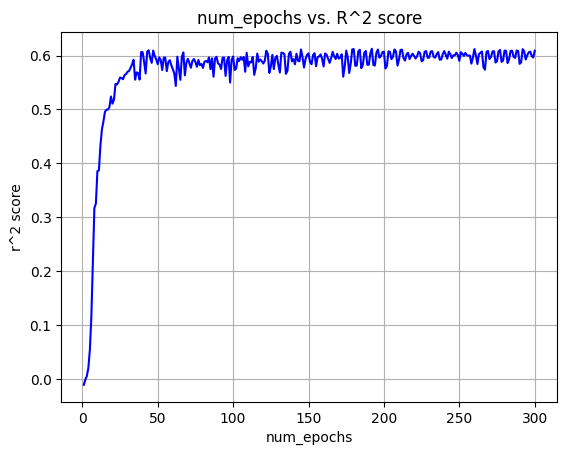

In [27]:
plt.plot(num_epochs_list, r2_scores_list, color='b', linestyle='-')
plt.title('num_epochs vs. R^2 score')
plt.xlabel('num_epochs')
plt.ylabel('r^2 score') 
plt.grid(True)
plt.show() 

In [28]:
max_r2_score = max(r2_scores_list)
corresponding_rmse = rmse_list[r2_scores_list.index(max_r2_score)]
corresponding_num_epochs = num_epochs_list[r2_scores_list.index(max_r2_score)]

print(f'Max R^2 score: {max_r2_score}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.6125282892988142
Corresponding RMSE: 0.18839561922481116
Corresponding num_epochs: 192
